Prototype of MAF without needing bundles

In [1]:
import copy
import numpy as np
import healpy as hp
import sqlite3
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from os.path import basename

from slicer import (Slicer, MeanMetric, FancyMetric, VectorMetric, CoaddM5Metric, 
                    PlotMoll, gen_summary_row, CountMetric, PlotHist, 
                    PlotHealHist, PlotLine, PlotFo)

from rubin_sim.data import get_baseline

In [2]:
# Read in a small example visit history
baseline_file = get_baseline()
run_name = basename(baseline_file).replace('.db', '')
con = sqlite3.connect(baseline_file)
# Dataframe is handy for some calcs
df = pd.read_sql("select * from observations where night < 61;", con)
# But mostly want numpy array for speed.
visits_array = df.to_records(index=False)
con.close()

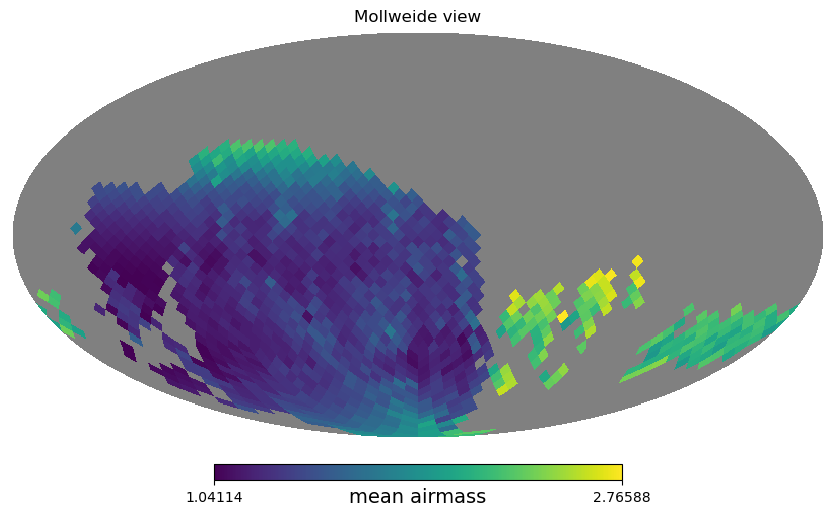

In [3]:
# Compute the mean airmass
sl = Slicer(nside=16)
metric = MeanMetric(col="airmass")
hp_array = sl(visits_array, metric)
hp.mollview(hp_array, unit="mean airmass")

In [4]:
hp_array

array([       nan,        nan,        nan, ..., 1.90011784, 2.20205168,
       1.99166173], shape=(3072,))

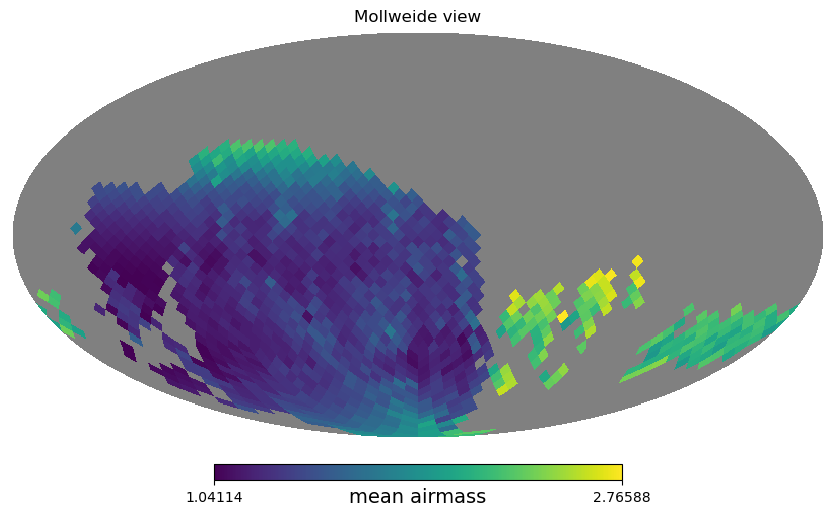

In [5]:
# Can even send in a lambda func
sl = Slicer(nside=16)
metric = lambda visits, **kwargs : np.mean(visits["airmass"])
hp_array = sl(visits_array, metric)
hp.mollview(hp_array, unit="mean airmass") 

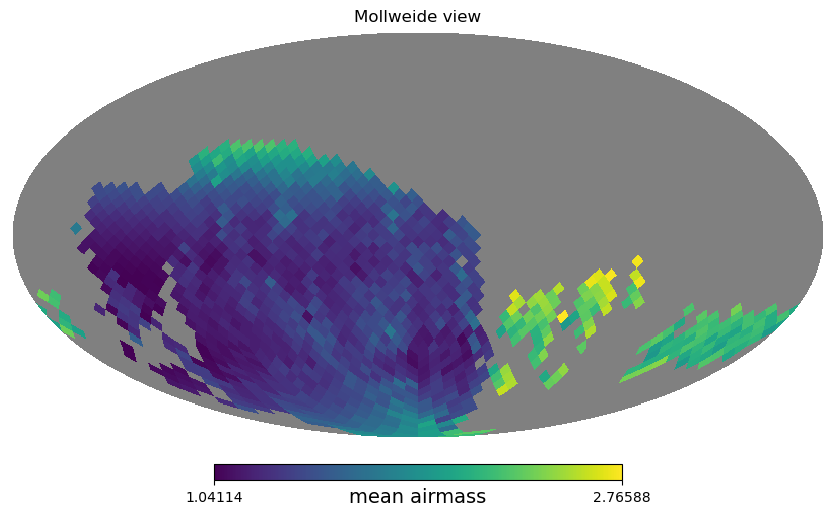

In [6]:
# but lambda funcs are verboten, so 
sl = Slicer(nside=16)
def ontheflymetric(visits, **kwargs):
    return np.mean(visits["airmass"])
hp_array = sl(visits_array, ontheflymetric)
hp.mollview(hp_array, unit="mean airmass") 

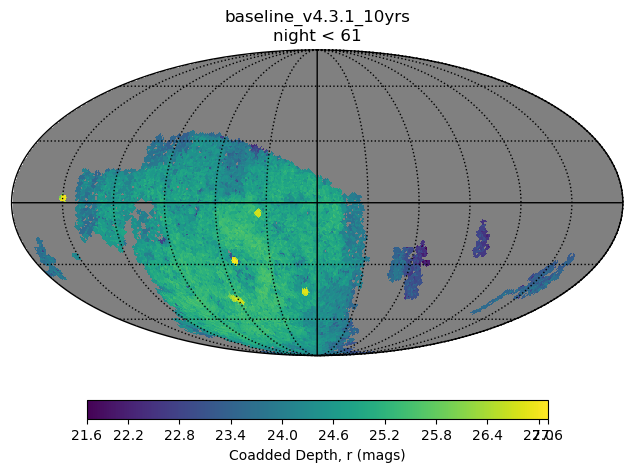

In [7]:
# let's do a whole coadded depth, similar to original maf call
filtername = "r"
info = {"run_name": "baseline_v4.3.1_10yrs",
        "observations_subset": "night < 61"}
# select subset of data
sub_data = visits_array[np.where(visits_array["filter"] == filtername)[0]]
metric = CoaddM5Metric(filtername)
sl = Slicer(nside=64)
hp_array, info = sl(sub_data, metric, info=info)
pm = PlotMoll(info=info)
fig = pm(hp_array)

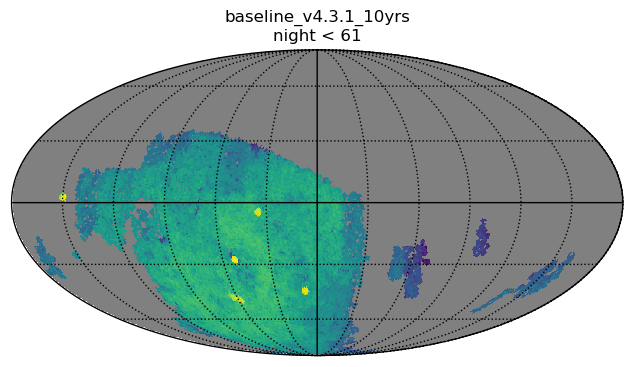

In [8]:
# can turn off colorbar
fig = pm(hp_array, cbar=False, cb_params=None)

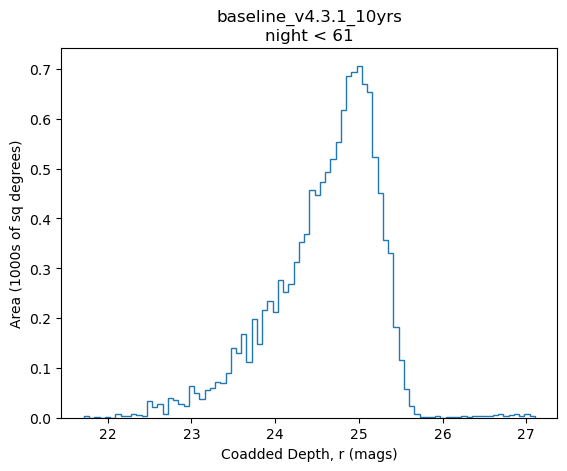

In [9]:
phh = PlotHealHist(info=info)
fig_hist = phh(hp_array)

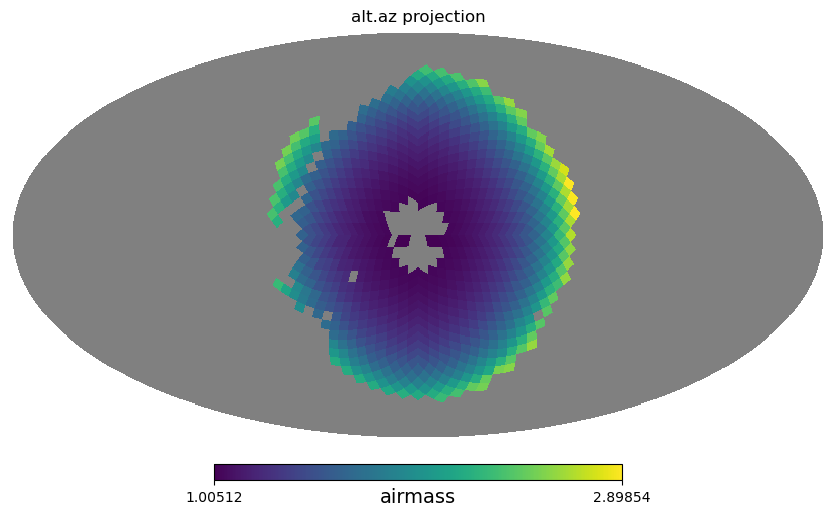

In [10]:
# Compute the mean of the airmass over the sky, in alt/az
sl = Slicer(nside=16, lon_col="azimuth", lat_col="altitude")
metric = MeanMetric(col="airmass")
hp_array = sl(visits_array, metric)
hp.mollview(hp_array, rot=(0,90), title="alt.az projection", unit="airmass")


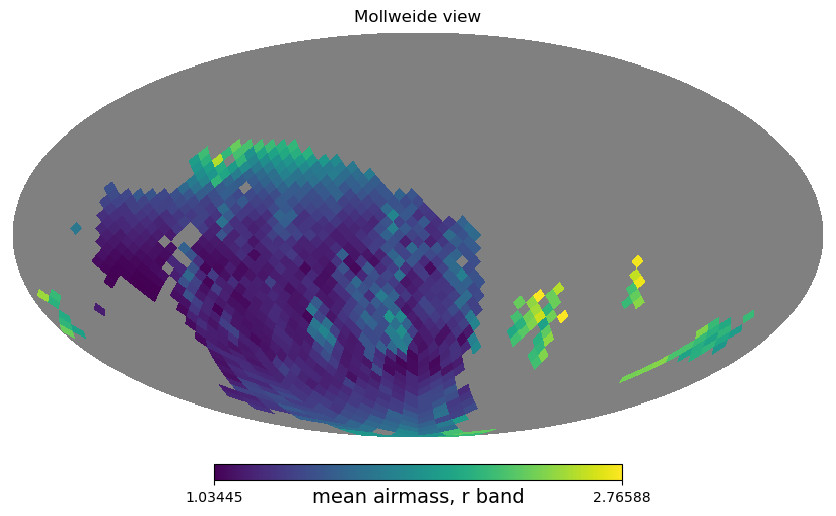

In [11]:
# select a subset of the data
r_data = visits_array[visits_array["filter"] == "r"]
sl = Slicer(nside=16)
result = sl(r_data, metric)
hp.mollview(result, unit="mean airmass, r band")

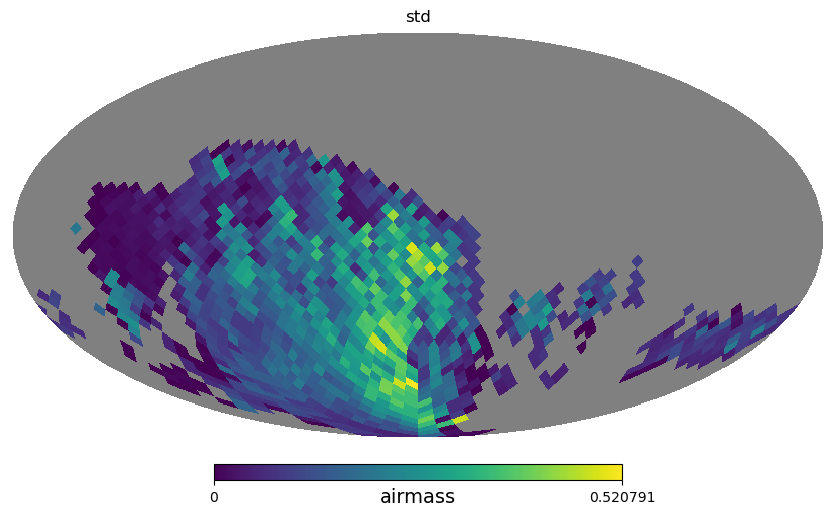

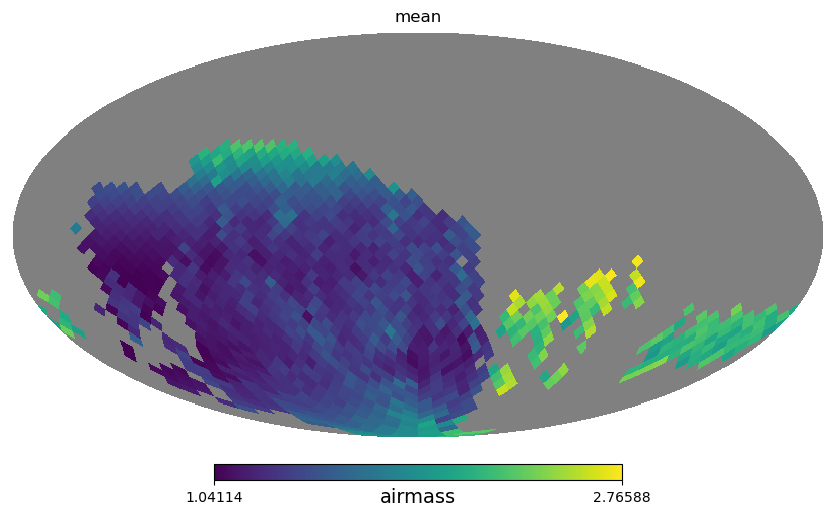

In [12]:
# A metric that returns multiple values at each healpix, 
# e.g., N SN and z lim, or detection and classification
fancy_result = sl(visits_array, FancyMetric(col="airmass"))
hp.mollview(fancy_result["std"], title="std", unit="airmass")
hp.mollview(fancy_result["mean"], title="mean", unit="airmass")


Text(0, 0.5, 'Median visits over sky')

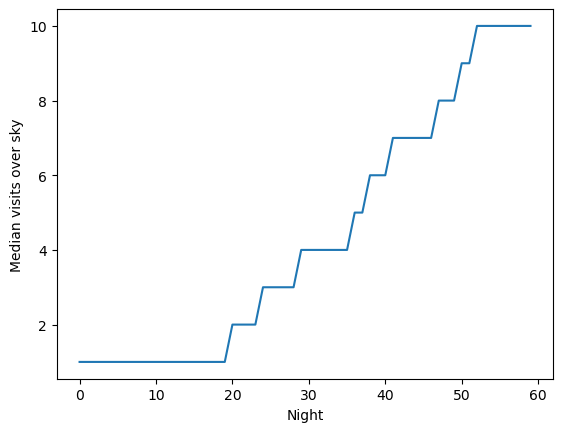

In [13]:
# A vector metric example
times = np.arange(60)
sl = Slicer(nside=16, missing=np.nan)
vm_result = sl(visits_array, VectorMetric(times=times))
med = np.nanmedian(vm_result, axis=0)

plt.plot(times, med)
plt.xlabel("Night")
plt.ylabel("Median visits over sky")

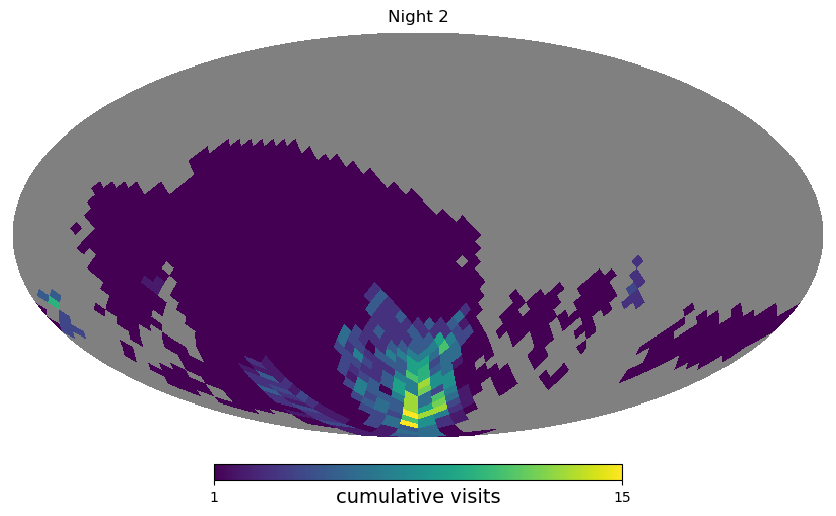

In [14]:
# A slice of the vector metric result
hp.mollview(vm_result[:,2], title="Night 2", unit="cumulative visits")

In [15]:
# let's make the FOnV data
asky=18000.0
stat=np.nanmedian
n_pix_heal = vm_result[:,0].size
nside = hp.npix2nside(n_pix_heal)
pix_area = hp.nside2pixarea(nside, degrees=True)
n_pix_needed = int(np.ceil(asky/pix_area))
# sort by value
vm_result.sort(axis=0)
# Crop down to the desired sky area
result = vm_result[n_pix_heal-n_pix_needed:, :]
result = stat(vm_result, axis=0)


/Users/yoachim/git_repos/25_scratch/maf_simple/slicer.py:870: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize="small", numpoints=1, framealpha=1.0)


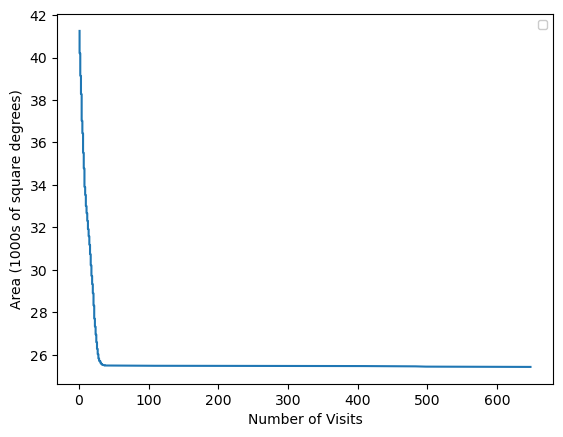

In [16]:
pfo = PlotFo()
fig = pfo(vm_result[:,-1])

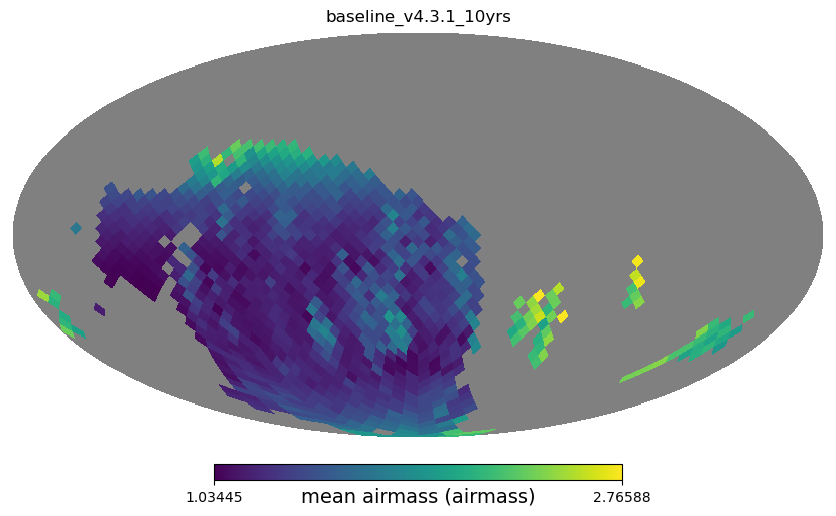

In [17]:
# Use a dict to pass along information for plots
info = {"run_name": "baseline_v4.3.1_10yrs"}
sl = Slicer(nside=16)
result, info = sl(r_data, metric, info=info)
hp.mollview(result, title=info["run_name"], unit=info["metric: name"]+' '+info["metric: col"]+' ('+info["metric: unit"]+')')

In [18]:
info

{'run_name': 'baseline_v4.3.1_10yrs',
 'slicer: nside': 16,
 'metric: name': 'mean',
 'metric: col': 'airmass',
 'metric: unit': 'airmass'}

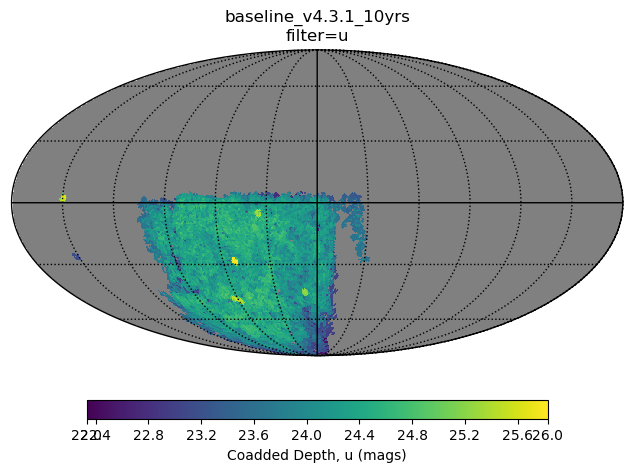

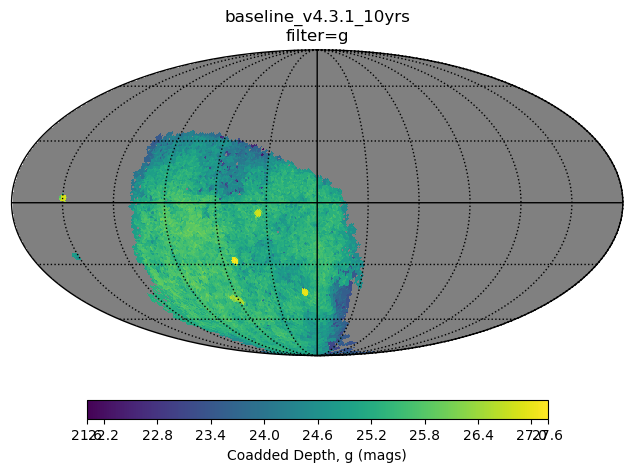

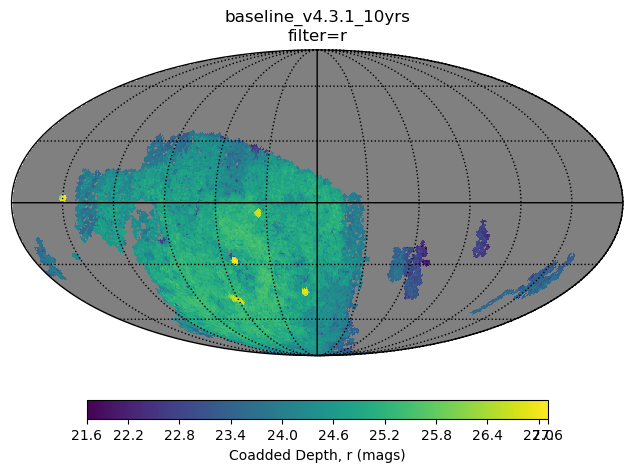

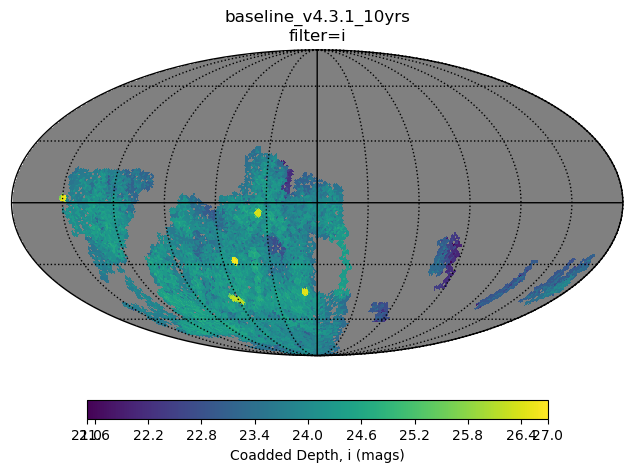

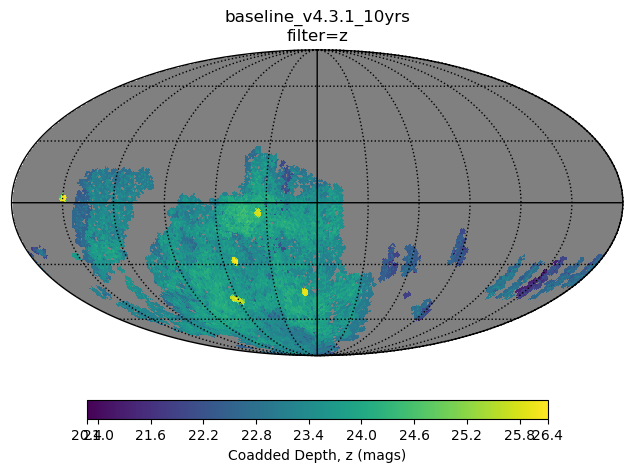

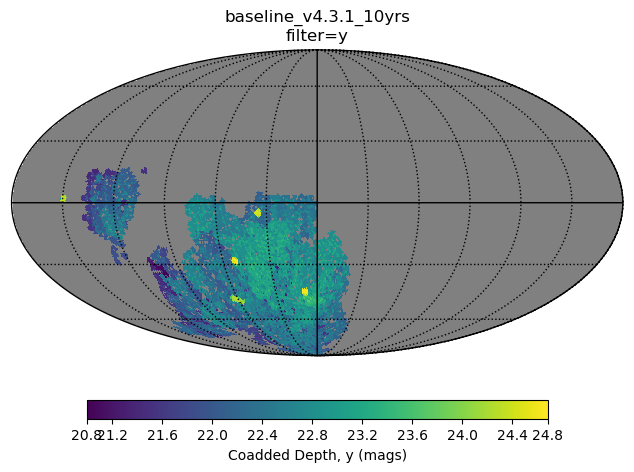

In [19]:
# Coadded depth maps in each filter, then mean and medians of those maps, use 
# a dict to keep track of info to help auto-generate plot labels.

summary_stats = []

for i,filtername in enumerate('ugrizy'):
    info = {"run_name": "baseline_v4.3.1_10yrs"}
    info["observations_subset"] =  "filter=%s" % filtername
    # select subset of data
    sub_data = visits_array[np.where(visits_array["filter"] == filtername)[0]]
    metric = CoaddM5Metric(filtername)
    sl = Slicer(nside=64)
    # info dict used to auto-generate plot labels. Can override with plot_dict
    hp_array, info = sl(sub_data, metric, info=info)
    pm = PlotMoll(info=info)
    fig = pm(hp_array)
    # Do whatever stats we want on the hp_array
    summary_stats.append(gen_summary_row(info, "mean", np.nanmean(hp_array)))
    summary_stats.append(gen_summary_row(info, "median", np.nanmedian(hp_array)))


In [20]:
pd.DataFrame(summary_stats)

,run_name,observations_subset,slicer: nside,metric: name,metric: col,metric: unit,summary_name,value
0,baseline_v4.3.1_10yrs,filter=u,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, u (mags)",mean,24.166482
1,baseline_v4.3.1_10yrs,filter=u,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, u (mags)",median,24.244780
2,baseline_v4.3.1_10yrs,filter=g,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, g (mags)",mean,25.134757
3,baseline_v4.3.1_10yrs,filter=g,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, g (mags)",median,25.252899
4,baseline_v4.3.1_10yrs,filter=r,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, r (mags)",mean,24.602991
5,baseline_v4.3.1_10yrs,filter=r,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, r (mags)",median,24.734130
6,baseline_v4.3.1_10yrs,filter=i,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, i (mags)",mean,23.923856
7,baseline_v4.3.1_10yrs,filter=i,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, i (mags)",median,23.986725
8,baseline_v4.3.1_10yrs,filter=z,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, z (mags)",mean,23.401246
9,baseline_v4.3.1_10yrs,filter=z,64,CoaddM5Metric,fiveSigmaDepth,"Coadded Depth, z (mags)",median,23.472468


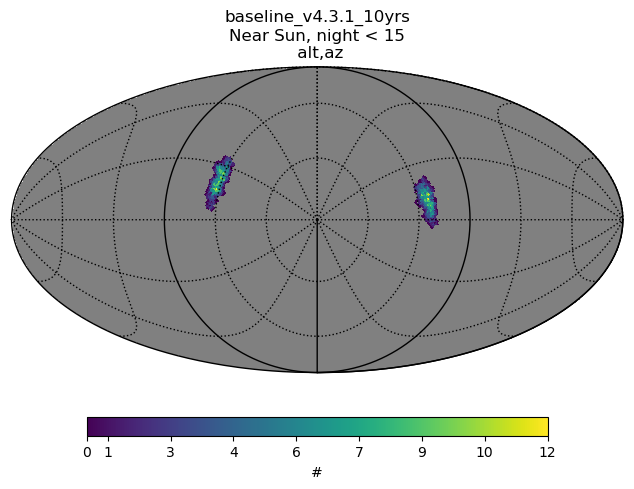

In [21]:
# Example with multiple data selection criteria from a DataFrame, 
#use kwargs to override some info dict auto-generated labels
info = {"run_name": "baseline_v4.3.1_10yrs"}
info["observations_subset"] =  "Near Sun Twilight Observations, night < 15"
#sub_data = df[(df["scheduler_note"].str.contains("_near_sun")) & (df["night"] < 15)]
# How do I 
sub_data = visits_array[ (np.char.find(visits_array["scheduler_note"].astype(str),"_near_sun") != -1) & (visits_array["night"] < 15)]
metric = CountMetric()
sl = Slicer(nside=64, lat_col="altitude", lon_col="azimuth")
hp_array, info = sl(sub_data, metric, info=info)
title = info["run_name"]+'\n'+"Near Sun, night < 15"+'\n alt,az'
pm = PlotMoll(info=info)
fig = pm(hp_array, rot=(0,90), title=title, cb_params={"format": "%i"})


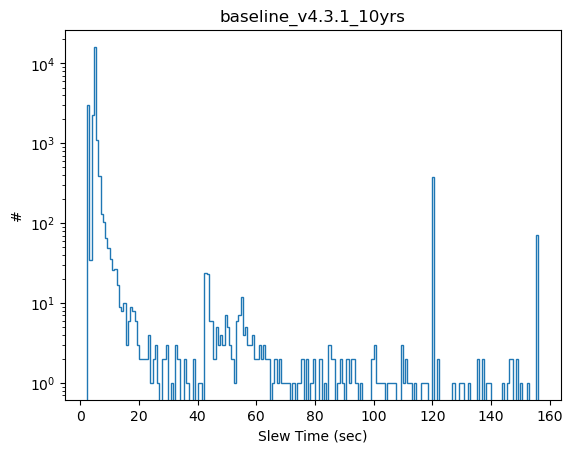

In [22]:
# make a histogram of the slewtimes
info = {"run_name": "baseline_v4.3.1_10yrs"}
info["metric: unit"] = "Slew Time (sec)"
# Maybe this is just a function and not a class
ph = PlotHist(info=info)
fig = ph(visits_array["slewTime"], log=True)
# then something like:
# show_maf_log = ShowMafLog(output_dir)
# show_maf_log.fig_to_showmaf(fig, info)

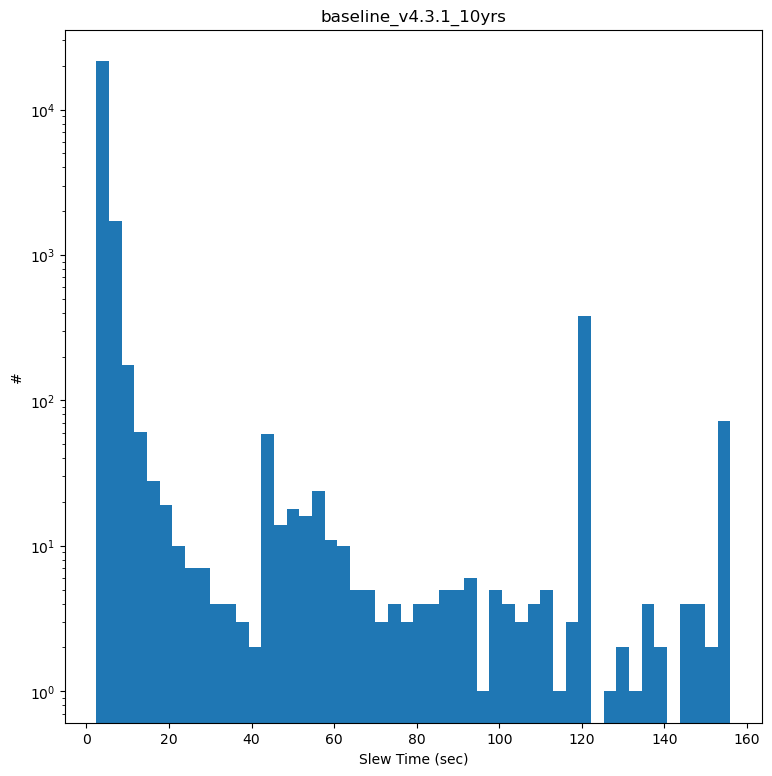

In [23]:
# if I want a big figure, can set my own figure up
fig, ax = plt.subplots(figsize=(9, 9))
fig = ph(visits_array["slewTime"], log=True, bins=50, histtype="bar", fig=fig, ax=ax)

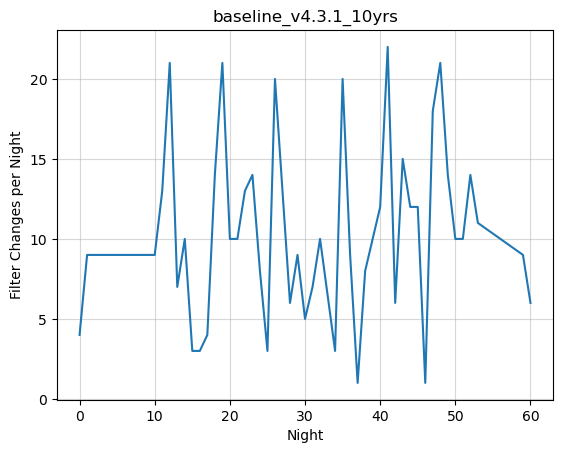

In [24]:

def count_value_changes(inarr):
    return np.sum(inarr[1:].values != inarr[:-1].values)

stats = {"mean": np.mean, "median": np.median, "count changes": count_value_changes}
info={"run_name": run_name}

fpn = df.groupby("night")["filter"].apply(count_value_changes)
pl = PlotLine(info=info)
fig = pl(fpn.index, fpn.values, xlabel="Night", ylabel="Filter Changes per Night")
mean_fpn = fpn.mean()
median_fpn = np.median(fpn)
# All filter changes, use fpn.sum() to not count start/end of night changes.
total_filter_changes = count_value_changes(df["filter"])

# So could do something like
#for stat_name in stats:
#    results_connection.add_stat(stat_name, stats[stat_name](fpn), info=info)


In [25]:
total_filter_changes, fpn.sum()


(np.int64(501), np.int64(467))